In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm

import utils.data_processing as dp
import matplotlib.pyplot as plt

from utils.UNeXt import UNet
from utils.loss import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

# Build dataset

In [17]:
batch_size = 8
num_workers = 8

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

# Dataset
directory  = './data/ZyxAct_16kPa_small/'
test_cells = 'cell_1'


in_channels  = [[6],[7]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (2,3)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels, 
                    'vector_components': [out_channels, (0,1)],
                    'magnitude_only': False,
                    'angmag': True,
                    'norm_output': {'rescale': 0.25, 'threshold': 0.4},
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'outside_inside', # Comment on what these do
                    'output_baseline_normalization': 'mean_dataset',
                    'remake_dataset_csv': True,
                    'exclude_frames': [31,90]
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [7]:
df = dataset.info.copy()

df.head(10)

,index,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in,F_mean,F_max
0,0,cell_0,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
1,1,cell_0,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
2,2,cell_0,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
3,3,cell_0,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
4,4,cell_0,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
5,5,cell_0,Disp_Trac_CellMask_ForceMask_Actin_5.npy,5,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
6,6,cell_0,Disp_Trac_CellMask_ForceMask_Actin_6.npy,6,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
7,7,cell_0,Disp_Trac_CellMask_ForceMask_Actin_7.npy,7,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
8,8,cell_0,Disp_Trac_CellMask_ForceMask_Actin_8.npy,8,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
9,9,cell_0,Disp_Trac_CellMask_ForceMask_Actin_9.npy,9,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516


In [8]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_1']}
[233 184 243 188 230 220 241 229 207 222 209 200 235 195 231 223 198 238
 208 203 239 205 226 237 201 210 236 194 192 213 214 217 189 227 187 219
 212 225 202 224 196 218 206 204 197 211 240 221 242 185 193 191 234 215
 183 199 232 190 186 216]


{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'output': torch.Size([2, 512, 512]), 'displacements': torch.Size([2, 512, 512])}


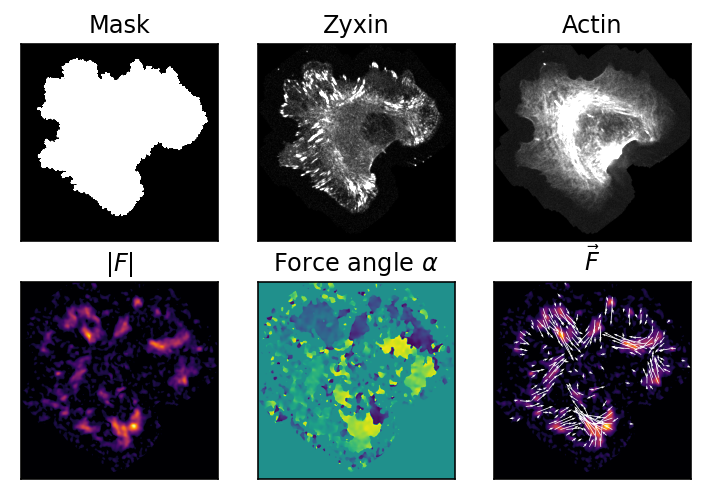

In [20]:
fig,ax=plt.subplots(2,3,figsize=(2*3, 2*2), dpi=144)

cell = 'cell_1'
frame = 5

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.

sample = dataset[idx] # get item

print({key: sample[key].shape for key in sample.keys()})


ax[0][0].set_title('Mask')
ax[0][0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[0][1].set_title('Zyxin')
ax[0][1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=3, vmin=0)
ax[0][2].set_title('Actin')
ax[0][2].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1][0].set_title('$|F|$')
ax[1][0].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno')
ax[1][1].set_title('Force angle $\\alpha$')
ax[1][1].imshow(sample['output'].squeeze()[1], origin='lower', vmax=np.pi, vmin=-np.pi)
ax[1][2].set_title('$\\vec{F}$')
ax[1][2].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno')
ax[1][2].quiver(*nb_utils.make_vector_field(*sample['output'].squeeze(), downsample=15, threshold=0.4, angmag=True), color='w', scale=20)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Build U-Net model with ConvNext blocks

In [21]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'am',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }





models = {}
for protein in ['zyxin', 'actin']:
    modelname = 'model_0'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 20}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein, 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'strainenergy_regularization': 0.0, 'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'loss_kwargs': {'max_force': 8.0}}
LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'strainenergy_regularization': 0.0, 'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'loss_kwargs': {'max_force': 8.0}}


# Perform training

In [9]:
save_models = False
n_epochs = 150

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()

    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))

    # SAVE
    if save_models:
        # Log in tensorboard
        for mkey in models.keys():
            model[mkey].log_images(epoch=e)
            model[mkey].log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


  0%|          | 0/3200.0 [00:00<?, ?it/s]

Epoch 0:	 Time: 42.65 	(per epoch: 42.65)
Epoch 1:	 Time: 81.89 	(per epoch: 40.95)
Epoch 2:	 Time: 121.03 	(per epoch: 40.34)
Epoch 3:	 Time: 159.80 	(per epoch: 39.95)
Epoch 4:	 Time: 198.60 	(per epoch: 39.72)
Epoch 5:	 Time: 238.29 	(per epoch: 39.71)
Epoch 6:	 Time: 277.52 	(per epoch: 39.65)
Epoch 7:	 Time: 317.03 	(per epoch: 39.63)
Epoch 8:	 Time: 356.29 	(per epoch: 39.59)
Epoch 9:	 Time: 395.08 	(per epoch: 39.51)
Epoch 10:	 Time: 435.05 	(per epoch: 39.55)
Epoch 11:	 Time: 474.15 	(per epoch: 39.51)
Epoch 12:	 Time: 512.99 	(per epoch: 39.46)
Epoch 13:	 Time: 552.23 	(per epoch: 39.45)
Epoch 14:	 Time: 591.28 	(per epoch: 39.42)
Epoch 15:	 Time: 630.51 	(per epoch: 39.41)
Epoch 16:	 Time: 670.05 	(per epoch: 39.41)
Epoch 17:	 Time: 709.77 	(per epoch: 39.43)
Epoch 18:	 Time: 749.31 	(per epoch: 39.44)
Epoch 19:	 Time: 788.35 	(per epoch: 39.42)
Epoch 20:	 Time: 827.79 	(per epoch: 39.42)
Epoch 21:	 Time: 867.13 	(per epoch: 39.42)
Epoch 22:	 Time: 906.36 	(per epoch: 39.41)


# Plot prediction on train cell

torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


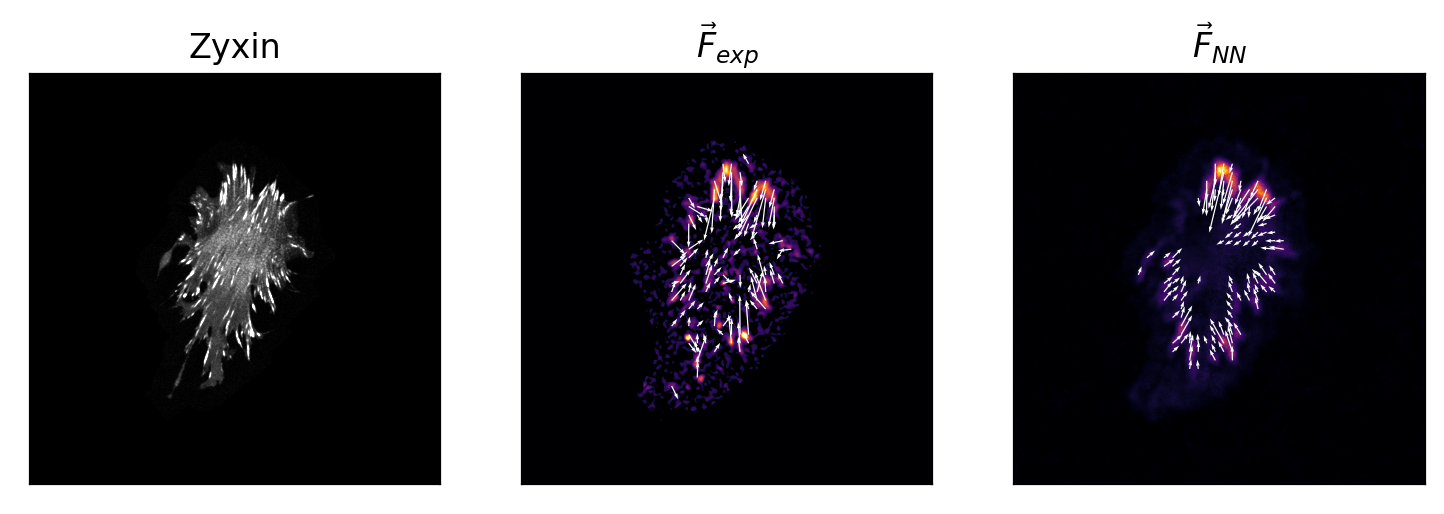

In [31]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_3'
frame = 0

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=3, vmin=0)

ax[1].set_title('$\\vec{F}_{exp}$')
ax[1].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[1].quiver(*nb_utils.make_vector_field(*sample['output'].squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

ax[2].set_title('$\\vec{F}_{NN}$')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[2].quiver(*nb_utils.make_vector_field(*pred.squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Performance on test cell
## It seems to underpredict quite dramatically, but we don't necessarily expect great generalization because the network was trained on an extremely small dataset (~180 frames).

torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


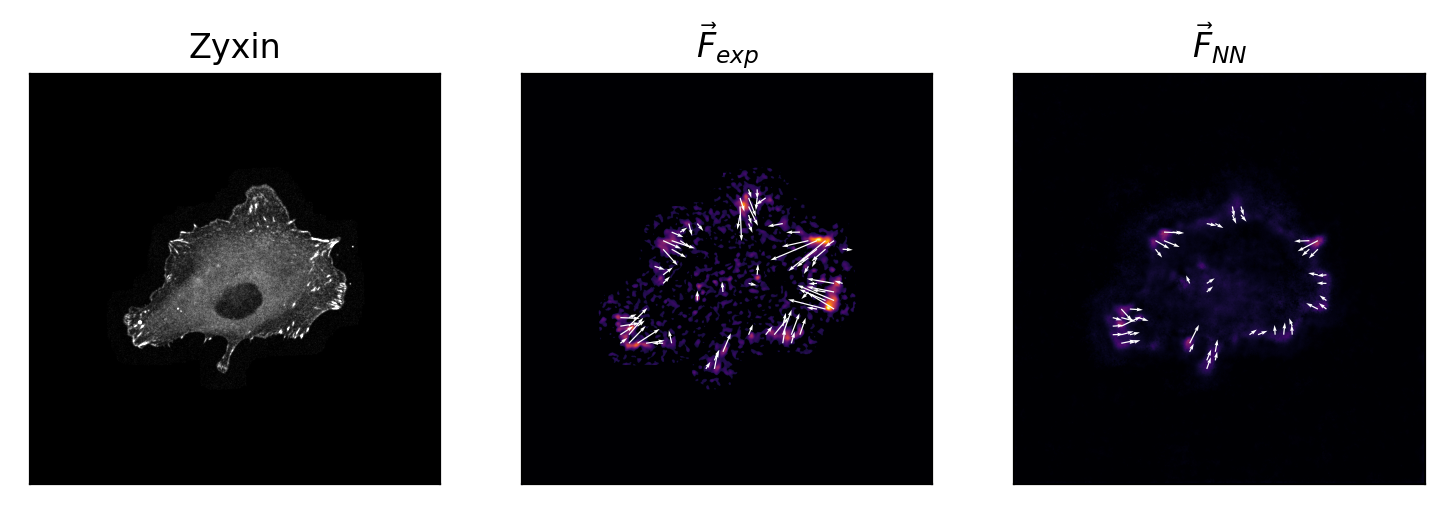

In [32]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 100

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=3, vmin=0)

ax[1].set_title('$\\vec{F}_{exp}$')
ax[1].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[1].quiver(*nb_utils.make_vector_field(*sample['output'].squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

ax[2].set_title('$\\vec{F}_{NN}$')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[2].quiver(*nb_utils.make_vector_field(*pred.squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])